In [1]:
# https://datascience-enthusiast.com/R/ML_python_R_part2.html
library(readxl)
library(tidyverse)
library(xgboost)
library(caret)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




# XGBoost (eXtreme Gradient Boosting)
An ensemble model that leverages boosting to transform a Decision Tree basd-model from a weak, to a strong learner. 

A tree boosting model uses the misclassifed points from the previous Decision Tree to train the model's next tree. Each tree therefore learns from and improves upon the performance of the last. More weight is allocated to the most accurate trees, and aggregating this weighted average yields a better overall model.

The process of training models sequentially on the prior model's errors, or residuals, essentially uses gradient descent to optimize the objective function. This is a commonly seen with Gradient Boosting. XGBoost improves on normal gradient boosting as it reduces execution speed via parallel computing. It also utlizes regularization techniques that control the model's complexity and help to avoid overfitting. 

xgboost may not be the best algorithm out there when all the features are categorical or when the number of rows is less than the number of columns.

## import data and check data attributes (NAs, column d_types, etc.)

In [2]:
ml_data <- read.csv('ml_predict_data.csv')

In [3]:
# assign countyname col to ml_data idx
row.names(ml_data) <- ml_data$X
# drop X col
drops <- c('X')
ml_data <- ml_data[, !(names(ml_data) %in% drops)]

In [4]:
ml_data

,avg_perc_change,new_case_count_sum,religion,civic,charitable,fraternal,union,voteage,local,state,⋯,politicalacts,ethnic,ethnichpn,education,incomeequal,employ,genderincome,language,commu,nonelder
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"Kent County, Delaware",-0.10410000,6374,0.04128665,0.09236666,0.5138504,0.3680297,0.3876543,0.5415052,0.11346269,0.25280786,⋯,0.5021771,0.3970396,0.7951538,0.6537678,0.5456621,0.502883500,0.1139325500,0.9028321,0.9300119,0.9998395
"New Castle County, Delaware",-0.10694205,17440,0.02607471,0.10866666,0.4709141,0.2620818,0.5456790,0.5250972,0.08217630,0.13572581,⋯,0.5428157,0.3789706,0.7014812,0.6364562,0.4657534,0.579008040,0.0697858300,0.8534756,0.9332486,0.9999564
"Sussex County, Delaware",0.07530081,6625,0.06673288,0.08693332,0.1149585,0.1003717,0.2641975,0.5858911,0.09865325,0.16121109,⋯,0.3149492,0.5357585,0.7088547,0.5315682,0.4954338,0.477508660,0.0725594200,0.9003864,0.9184142,0.9998007
"Calhoun County, Alabama",-0.01198159,4954,0.14416942,0.09779999,0.2728532,0.2825279,0.2740741,0.5931206,0.14542660,0.10854987,⋯,0.2989840,0.4907753,0.8822994,0.6344196,0.4383562,0.389850080,0.2552950400,0.9534703,0.8962063,0.9997735
"Colbert County, Alabama",-0.80248864,1936,0.15907682,0.06519999,0.2880887,0.2713755,0.3308642,0.6142046,0.18445593,0.08697174,⋯,0.2235123,0.5912497,0.9221585,0.5814664,0.4794521,0.452133770,0.2414003000,0.9728736,0.9124165,0.9994222
"Cullman County, Alabama",0.15002955,4038,0.17756705,0.08149999,0.2188366,0.2676580,0.3753086,0.5765867,0.15217362,0.08567087,⋯,0.1770682,0.8998702,0.8476726,0.6059063,0.4566210,0.470588270,0.0774006840,0.9561338,0.8671177,0.9996407
"Dale County, Alabama",-0.25647727,3255,0.12937844,0.07606666,0.2396122,0.2397769,0.3333333,0.5566893,0.15729527,0.06966214,⋯,0.2975327,0.4786251,0.8013721,0.6476579,0.5045662,0.445213380,0.4270797400,0.9349950,0.8601150,0.9994912
"Escambia County, Alabama",-0.08107500,2295,0.20798197,0.07606666,0.2313019,0.2118959,0.3259259,0.5969077,0.23886412,0.13833724,⋯,0.1930334,0.3449723,0.9254362,0.4439918,0.4132420,0.322952700,0.0002392530,0.9835584,0.7481605,0.9992800
"Etowah County, Alabama",-0.17976136,4459,0.15017657,0.08149999,0.3144044,0.2936803,0.3679012,0.5862101,0.20284905,0.09484407,⋯,0.2815675,0.6019641,0.8806388,0.5651731,0.4383562,0.393310280,0.0658689740,0.9687377,0.8775314,0.9997147


## create test & train set indices with 80% of data using the caret package

In [5]:
set.seed(1)  # for reproducibility

# create index for testing and training data
inTrain <- createDataPartition(y = ml_data$avg_perc_change, p = 0.8, list = FALSE)

# subset ml_data to train
training <- ml_data[inTrain,]


# subset the rest to test
testing <- ml_data[-inTrain,]

## convert test & train set to DMatrixes as DMatrix is the recommended class for xgboost

In [47]:
data = as.matrix(training %>% select(-avg_perc_change))

label = as.numeric(training$avg_perc_change)

X_test = xgb.DMatrix(as.matrix(testing %>% select(-avg_perc_change)))
y_test = testing$avg_perc_change

# #preparing matrix 
# dtrain <- xgb.DMatrix(data = X_train, label = y_train) 
# dtest <- xgb.DMatrix(data = X_test, label = y_test)

## train model with default params to set baseline performance

In [15]:
params <- list(booster = "xgbTree", 
               objective = "reg:squarederror", 
               max_depth=6, 
               min_child_weight=1, 
               subsample=1, 
               colsample_bytree=1)

In [ ]:
xgbcv <- xgb.cv(
    params = params, 
    data = dtrain, 
    nrounds = 100, 
    nfold = 5, 
    showsd = T, 
    stratified = T, 
    print.every.n = 10, 
    early.stop.round = 20, 
    maximize = F
)

In [ ]:
min(xgbcv$test.error.mean)

## specify cross-validation method, number of k-folds and enable parallel computation 

In [42]:
xgb_trcontrol = list(
  method = "cv",
  number = 3,  
  allowParallel = TRUE,
  verboseIter = FALSE,
  returnData = FALSE
)

## define the grid space to search for the best hyperparameters with tree-based learners
 - **learning rate (eta)**: governs how quickly the model proceeds along the path of gradient descent. This dictates how quickly the model fits subsequent trees. A slower learning rate will prevent overfitting but slow model train time.
 
 - **regarlization**: the gamma, lambda and alpha hyperparameters are provided to implement regularization.
         - **gamma**: dictates the minimum loss reduction required to create a new split
         - **lambda**: L2, or Ridge, regularization
         - **alpha**: L1, or Lasso, regularization

 - **tree depth (max_depth)**: governs how deep (the number of levels) per tree. the larger the value, the more complex the model and the greater the chance of overfitting.

 - **minimum node size (min_child_weight)**:

 - **subsample**: dictates the percent of training data to sample for each tree. low values are commonly associated with underfitting, while high values yield an increased chance of overfitting.

 - **n_estimators**: governs the total number of base learners, i.e. total number of boosting rounds.
 
 - **colsample_bytree**: the number of features used per tree. typical values range between 0.5-0.9.
 
 - **scale_pos_weight**: handles class imbalance. a value of 1 will address high class imbalance.

In [40]:
xgb_grid <- list(
    nrounds = c(100, 200, 500, 1000),
    max_depth = c(5, 10, 15, 20, 25),
    colsample_bytree = seq(0.5, 0.9, length.out = 5),
    # values specified below are sklearn-api default values
    eta = c(0.001, 0.01, 0.1),
    alpha = c(0, 0.001, 0.005, 0.01, 0.05, 0.1),
    min_child_weight = c(1, 5, 10),
    subsample = 1
)

## train the model

In [48]:
# hyperparameter grid
hyper_grid <- expand.grid(
  eta = 0.01,
  max_depth = 3, 
  min_child_weight = 3,
  subsample = 0.5, 
  colsample_bytree = 0.5,
  gamma = c(0, 1, 10, 100, 1000),
  lambda = c(0, 1e-2, 0.1, 1, 100, 1000, 10000),
  alpha = c(0, 1e-2, 0.1, 1, 100, 1000, 10000),
  rmse = 0,          # a place to dump RMSE results
  trees = 0          # a place to dump required number of trees
)

# grid search
for(i in seq_len(nrow(hyper_grid))) {
  set.seed(123)
  m <- xgb.cv(
    data = data,
    label = label,
    nrounds = 4000,
    objective = "reg:linear",
    early_stopping_rounds = 50, 
    nfold = 5,
    verbose = 0,
    params = list( 
      eta = hyper_grid$eta[i], 
      max_depth = hyper_grid$max_depth[i],
      min_child_weight = hyper_grid$min_child_weight[i],
      subsample = hyper_grid$subsample[i],
      colsample_bytree = hyper_grid$colsample_bytree[i],
      gamma = hyper_grid$gamma[i], 
      lambda = hyper_grid$lambda[i], 
      alpha = hyper_grid$alpha[i]
    ) 
  )
  hyper_grid$rmse[i] <- min(m$evaluation_log$test_rmse_mean)
  hyper_grid$trees[i] <- m$best_iteration
}

# results
hyper_grid %>%
  filter(rmse > 0) %>%
  arrange(rmse) %>%
  glimpse()

[18:57:17] WARNING: amalgamation/../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:17] WARNING: amalgamation/../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:17] WARNING: amalgamation/../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:17] WARNING: amalgamation/../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:17] WARNING: amalgamation/../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:20] WARNING: amalgamation/../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:20] WARNING: amalgamation/../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:20] WARNING: amalgamation/../src/objective/regression_obj.cu:171: reg

Rows: 245
Columns: 10
$ eta              <dbl> 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,…
$ max_depth        <dbl> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,…
$ min_child_weight <dbl> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,…
$ subsample        <dbl> 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5…
$ colsample_bytree <dbl> 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5…
$ gamma            <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ lambda           <dbl> 1e+03, 1e+03, 1e+03, 1e+03, 1e+02, 1e+02, 1e+02, 1e+0…
$ alpha            <dbl> 0.10, 0.00, 0.01, 1.00, 0.10, 0.00, 0.01, 1.00, 1.00,…
$ rmse             <dbl> 0.1606684, 0.1607112, 0.1607178, 0.1608388, 0.1611012…
$ trees            <dbl> 3611, 3382, 3382, 3655, 853, 853, 853, 853, 572, 572,…


## best hyperparameter values

In [49]:
xgb_model$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
103,500,5,0.01,0,0.5,1,1


## evaluate the model
mae - Mean Absolute Error (used in regression)
RMSE - Root mean square error (used in regression)
error - Binary classification error rate [#wrong cases/#all cases]

In [50]:
predicted = predict(xgb_model, X_test)
residuals = y_test - predicted
RMSE = sqrt(mean(residuals^2))

cat('The root mean square error of the test data is ', RMSE, '\n')

The root mean square error of the test data is  0.1567825 


In [51]:
y_test_mean = mean(y_test)

# Calculate total sum of squares
tss =  sum((y_test - y_test_mean)^2 )

# Calculate residual sum of squares
rss =  sum(residuals^2)

# Calculate R-squared
rsq  =  1 - (rss/tss)
cat('The R-square of the test data is ', round(rsq,3), '\n')

The R-square of the test data is  0.021 


## plot actual vs predicted 

`geom_smooth()` using formula 'y ~ x'



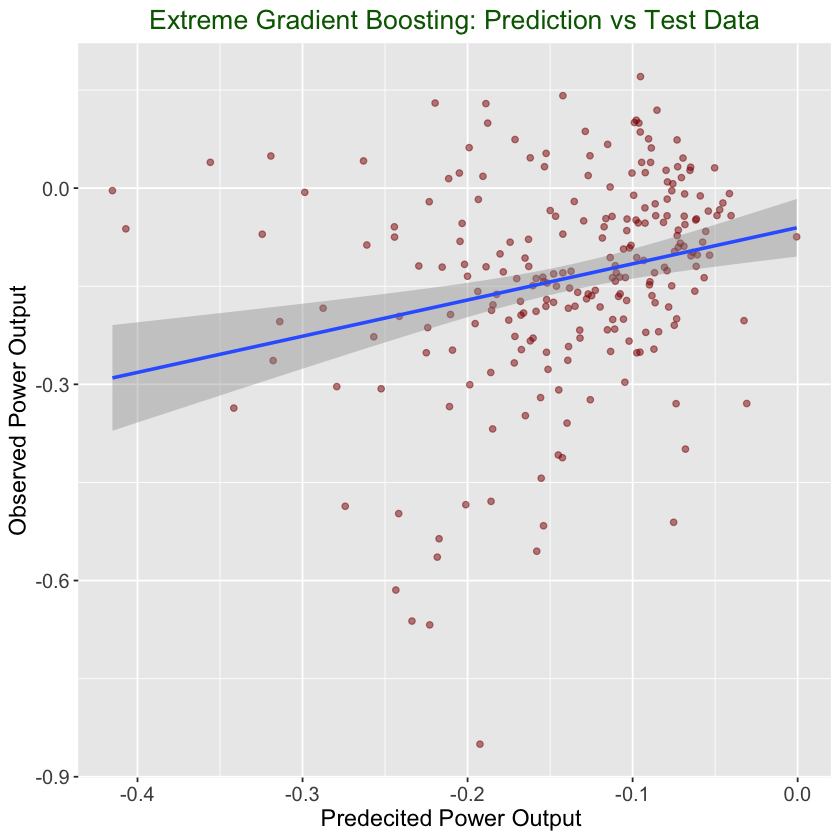

In [52]:
my_data = as.data.frame(cbind(predicted = predicted, observed = y_test))

# Plot predictions vs test data
ggplot(my_data,aes(predicted, observed)) + geom_point(color = "darkred", alpha = 0.5) + 
    geom_smooth(method=lm)+ ggtitle('Linear Regression ') + ggtitle("Extreme Gradient Boosting: Prediction vs Test Data") +
      xlab("Predecited Power Output ") + ylab("Observed Power Output") + 
        theme(plot.title = element_text(color="darkgreen",size=16,hjust = 0.5),
         axis.text.y = element_text(size=12), axis.text.x = element_text(size=12,hjust=.5),
         axis.title.x = element_text(size=14), axis.title.y = element_text(size=14))

# Feature Importance

In [53]:
#view variable importance plot
mat <- xgb.importance (feature_names = colnames(X_train), model = xgb_model)
xgb.plot.importance(importance_matrix = mat[1:20])

ERROR: Error in xgb.importance(feature_names = colnames(X_train), model = xgb_model): model: must be an object of class xgb.Booster


In [54]:
naive_roc_auc_score <- function(y_true, y_pred) {
    num_same_sign <- 0
    num_pairs <- 0 
    
    for(a in 1:length(y_true))
    {
        for(b in 1:length(y_true))
        {
            if (y_true[a] > y_true[b]) {
                
                num_pairs <- num_pairs + 1
                
                if (y_pred[a] > y_pred[b]) {
                
                    num_same_sign <- num_same_sign + 1
                }
                else if (y_pred[a] == y_pred[b]) {
                    
                    num_same_sign <- num_same_sign + .5
                }
            }
        }
    }
    num_same_sign / num_pairs
}

In [55]:
naive_roc_auc_score(y_test, predicted)

[1] 0.6031374

# Sources
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/